In [1]:
import matplotlib.pyplot as plt
from IPython.display import Math, display
import numpy as np
import sympy as sp
from scipy import constants as const

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si
from twod_trap import PancakeTrap

In [2]:
initial_power = 49 * si.uW 

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0 * si.G / si.cm,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer=1 * si.um,

    m= 161 * const.value("atomic mass constant"),
    mu_b= 9.93 * const.value("Bohr magneton" ),
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

# Gradient to cancel gravity:

In [3]:
grav_grad = float(trap.subs(trap.m*const.g/trap.mu_b) /si.G*si.cm)
print(f"{grav_grad:.3f} G/cm")

2.847 G/cm


# Find waist for target aspect ration (1064nm)

In [4]:
eta_target = 9

waist = trap.subs(
    sp.solve(
        trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer() - eta_target,
        trap.waist_tweezer,
    )[0]
).evalf()

_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(
    Math(
        f"{sp.latex(trap.waist_tweezer)}\\left({_aspect_ratio_latex} = {eta_target}\\right)"
        f" = {waist/si.um:.2f}\\mathrm{{\\mu m}}"
    )
)

<IPython.core.display.Math object>

# For 532nm

In [5]:
trap[trap.wvl] = 532*si.nm
trap[trap.a] = 180* (4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c)

In [6]:
eta_target = 9

waist = trap.subs(
    sp.solve(
        trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer() - eta_target,
        trap.waist_tweezer,
    )[0]
).evalf()

_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(
    Math(
        f"{sp.latex(trap.waist_tweezer)}\\left({_aspect_ratio_latex} = {eta_target}\\right)"
        f" = {waist/si.um:.2f}\\mathrm{{\\mu m}}"
    )
)

<IPython.core.display.Math object>

# Ploting for different target aspect ratios

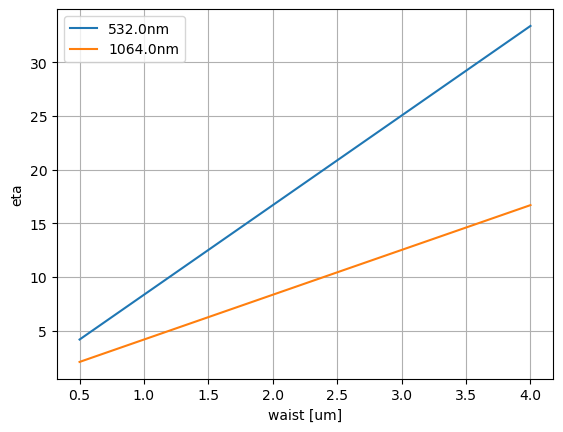

In [7]:
wvls = np.array([532, 1064]) * si.nm
waists = np.linspace(0.5,4) * si.um

for i, wvl in enumerate(wvls):
    eta = np.sqrt(2)*np.pi * waists/wvl
    plt.plot(waists/si.um,eta,label=f"{wvl/si.nm}nm")

plt.ylabel("eta")
plt.xlabel("waist [um]")
plt.grid()
plt.legend()
plt.show()

# Show that z-states are occupied first (532nm)

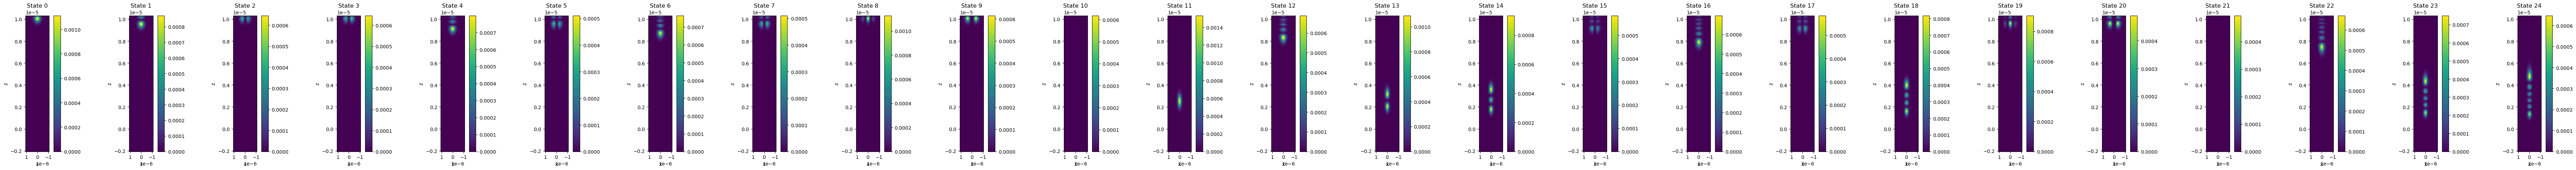

In [165]:
initial_power = 91 * si.uW 

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= -0.55 * si.G / si.cm,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer=1.08 * si.um,

    m= 161 * const.value("atomic mass constant"),
    mu_b= 9.93 * const.value("Bohr magneton" ),
    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 532 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

#### diagonalise

n_grid_1D = 80

n_pot_steps = [n_grid_1D,n_grid_1D,n_grid_1D]
n_levels = 100

left_cutoff = 1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
right_cutoff = -1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
back_cutoff = -1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
front_cutoff = 1*np.max([float(trap.subs(trap.waist_tweezer)),float(trap.subs(trap.waist_tweezer))])
bottom_cutoff = -0.3*np.max([float(trap.subs(trap.get_tweezer_rayleigh())),float(trap.subs(trap.get_tweezer_rayleigh()))])
top_cutoff = 1.5*np.max([float(trap.subs(trap.get_tweezer_rayleigh())),float(trap.subs(trap.get_tweezer_rayleigh()))])

extend = [(left_cutoff,right_cutoff),
        (back_cutoff,front_cutoff),
        (bottom_cutoff,top_cutoff)]

energies, states, potential, coords = trap.nstationary_solution(
                        [trap.x,trap.y,trap.z], extend, n_pot_steps, k=n_levels,
                        method="matrix_free", export=False, )

x = coords[trap.x]
y = coords[trap.y]
z = coords[trap.z]
x3D,y3D,z3D = np.meshgrid(coords[trap.x],coords[trap.y],coords[trap.z],indexing="ij")
pot = potential(x3D,y3D,z3D)


#### plot

n_states = 25

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(18/6*n_states, 5))  # Adjust the size as needed

# Loop over the state numbers from 0 to 5
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(np.abs(states[state_number, :, int(len(y)/2), :].T)**2, extent=[*extend[0], *extend[2]], origin="lower",
                   vmin=np.min(np.abs(states[state_number])**2), vmax=np.max(np.abs(states[state_number])**2))

    # Set labels for each subplot
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_title(f"State {state_number}")
    fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [166]:
initial_grad = float(trap.subs(1/trap.mu_b * (3*np.sqrt(3)/4 * initial_power * trap.a/np.pi/trap.waist_tweezer**2/zr - trap.m * trap.g)))
print(initial_grad/si.G*si.cm)

-0.003802379076607923


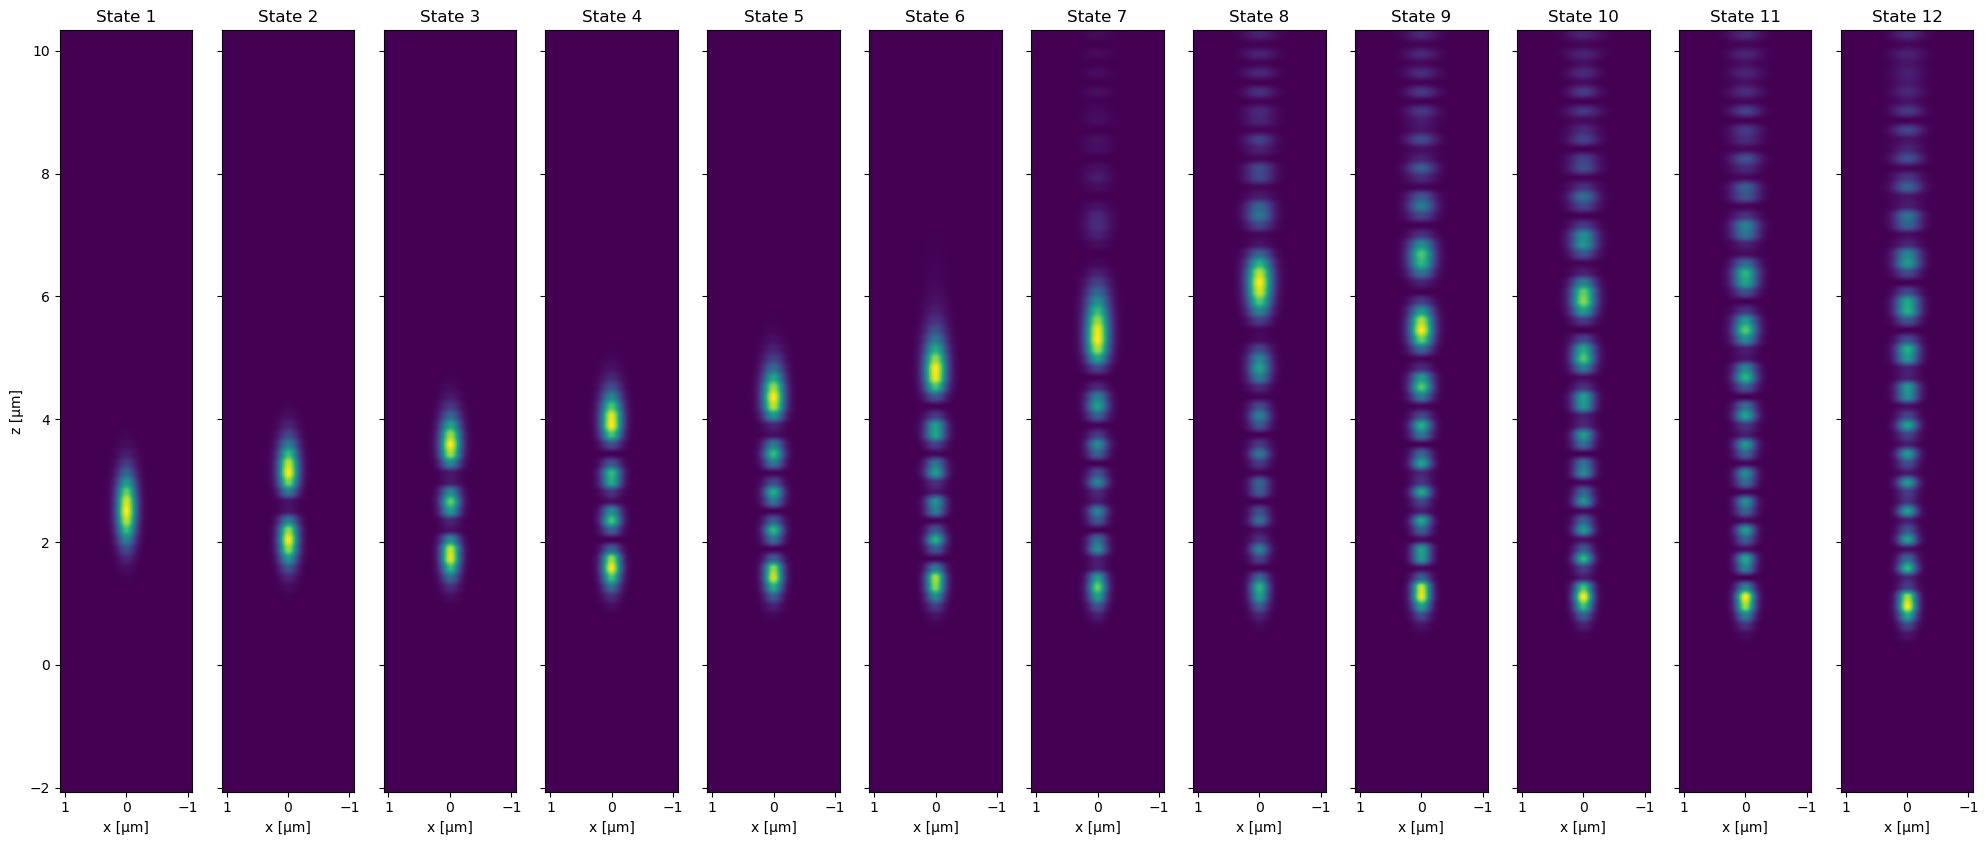

In [169]:
#find true bound states

from scipy.optimize import root_scalar

axial_width = trap.get_tweezer_rayleigh()

pot_ax = trap.subs(trap.get_potential())
pot_diff_ax = sp.diff(pot_ax, trap.z)
pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({trap.x: 0, trap.y: 0}))
pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({trap.x: 0, trap.y: 0}))
pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({trap.x: 0, trap.y: 0}))

barrier = root_scalar(
    pot_diff_ax_numpy,
    x0=1.5 * float(trap.subs(axial_width)),
    fprime=pot_diff2_ax_numpy,
    xtol=1e-18,
    fprime2=pot_diff3_ax_numpy,
).root
minimum = root_scalar(
        pot_diff_ax_numpy,
        x0=0,
        fprime=pot_diff2_ax_numpy,
        xtol=1e-28,
        fprime2=pot_diff3_ax_numpy,
    ).root

# States that are below the potential barrier
bound_states = energies < 0#potential(0,0,barrier)


# Density of states is larger on the left than on the right
# Likely that the state in question is a true bound state
true_bound_states = np.logical_and(
    bound_states,
    np.sum(np.abs(states[:,:,:, coords[trap.z] < barrier]) ** 2, axis=(1,2,3))
    > np.sum(np.abs(states[:,:,:, coords[trap.z] > barrier]) ** 2, axis=(1,2,3)),
)

# true_bound_states = np.full((len(true_bound_states)), False)
# true_bound_states[5] = True
# true_bound_states[10] = True
# true_bound_states[13] = True
# true_bound_states[14] = True
# true_bound_states[16] = True
# true_bound_states[20] = True

true_states = states[true_bound_states]


#### plot

n_states = 12

# Create a 1xn_states grid of subplots (1 row, n_states columns)
fig, axes = plt.subplots(1, n_states, figsize=(10/6*n_states, 5*1.8), sharey=True)  # Adjust the size as needed

# Remove horizontal space between axes
fig.subplots_adjust(wspace=5)

#use µm
plot_extent = [*extend[0], *extend[2]]
plot_extent = [x/si.um for x in plot_extent]

# Loop over the state numbers from 0 to 5
for state_number, ax in zip(range(n_states), axes):
    # Slice through the y-direction and rotate the x-z plane (by swapping x and z)
    im = ax.imshow(np.abs(true_states[state_number, :, int(len(y)/2), :].T)**2, extent=plot_extent, origin="lower",
                   vmin=np.min(np.abs(true_states[state_number])**2), vmax=np.max(np.abs(true_states[state_number])**2))

    # Set labels for each subplot
    ax.set_xlabel("x [µm]")
    if state_number == 0:
        ax.set_ylabel("z [µm]")
    ax.set_title(f"State {state_number+1}")
    #fig.colorbar(im, ax=ax)  

# Adjust layout for better spacing
plt.tight_layout()

#fig.colorbar(im, ax=axes.ravel().tolist())

plt.savefig("z-occupation_withgrad.png", dpi=300)

# Show the plots
plt.show()

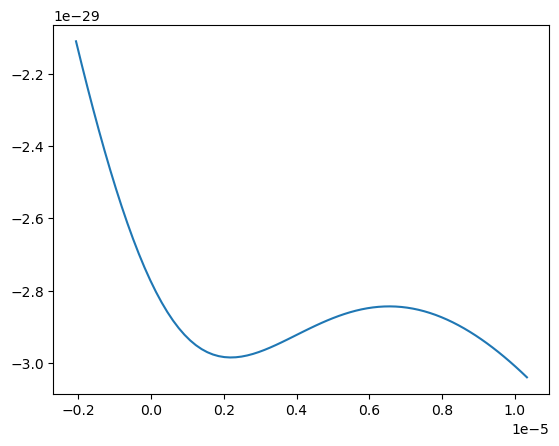

In [168]:
plt.plot(coords[trap.z],potential(0,0,coords[trap.z]))